In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.metrics import confusion_matrix


In [12]:
images = 'drumsdataset/mel_img'

In [13]:
#classes = ('cymbal', 'kick', 'snare', 'tom') #in order of folders

classes = ('ck', 'cymbal', 'kick', 'ks', 'snare' ,'tom')

In [52]:
class DrumsModel:
    def __init__(self, root, classes, train = False):
        self.root = root
        self.classes = classes
        
        transform = transforms.ToTensor()
        batch_size = 4
        num_workers = 2

        data = datasets.ImageFolder(root = self.root, transform = transform)

        #split train / test data
        if train == True:
            train = int(0.8 * len(data))
            test = len(data) - train
            train, test = random_split(data, [train, test])

            self.train_loader = DataLoader(train, batch_size = batch_size, shuffle = True, num_workers = num_workers)
            self.loader = DataLoader(test, batch_size = batch_size, shuffle = False, num_workers = num_workers)

        #load all data
        else:
            self.loader = DataLoader(data, batch_size = batch_size, shuffle = False, num_workers = num_workers)

    #returns images with truth & prediction
    def predpic(self):
        dataiter = iter(self.loader)
        images, labels = next(dataiter)

        # print images
        imgshow(torchvision.utils.make_grid(images))
        print('GroundTruth:', ' '.join('%s' % classes[labels[j]] for j in range(4)))

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        print('Predicted:', ' '.join('%s' % classes[predicted[j]] for j in range(4)))

    #returns highest model accuracy
    def accuracy(self):
        acc = 0
        count = 0
        predlst = []
        truth = []
        for inputs, labels in self.loader:
            outputs = net(inputs)
            acc += (torch.argmax(outputs, 1) == labels).float().sum()
            count += len(labels)
            _, pred = torch.max(outputs, 1)
            predlst.extend(pred.tolist())
            truth.extend(labels.tolist())
        acc /= count
        print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

        df = pd.DataFrame({'pred':predlst, 'true':truth})
        return(df)
    
    #returns confusion matrix
    def conf(self):
        pred = self.accuracy()['pred']
        truth = self.accuracy()['true']
        
        #confusion matrix
        conf = pd.DataFrame(confusion_matrix(truth, pred))
        conf.columns = self.classes
        conf.index = self.classes

        #accuracy column
        ckacc = conf['ck'][0] / int(sum(conf.loc['ck']))
        cymacc = conf['cymbal'][1] / int(sum(conf.loc['cymbal']))
        kickacc = conf['kick'][2] / int(sum(conf.loc['kick']))
        ksacc = conf['ks'][3] / int(sum(conf.loc['ks']))
        snareacc = conf['snare'][4] / int(sum(conf.loc['snare']))
        tomacc = conf['tom'][5] / int(sum(conf.loc['tom']))

        acc = [ckacc, cymacc, kickacc, ksacc, snareacc, tomacc]
        conf['acc'] = acc

        return(conf)

    #returns dataframe of predictions
    def predict(self):
        labs = {0:'ck', 1:'cymbal', 2:'kick', 3:'ks', 4:'snare' ,5:'toms'}
        predict = pd.DataFrame(self.accuracy()['pred'])

        drum = []
        for p in predict['pred']:
            drum.append(labs[p])

        predict['drum'] = drum

        return(predict)

In [15]:
dm = DrumsModel(images, classes, train = True)
#dm.conf()


In [17]:
dm.conf()

Epoch 14: model accuracy 93.48%
Epoch 14: model accuracy 93.48%


,ck,cymbal,kick,ks,snare,tom,acc
ck,2,0,0,0,0,0,1.000000
cymbal,0,10,0,0,0,0,1.000000
kick,0,0,10,1,0,0,0.909091
ks,0,0,2,4,0,0,0.666667
snare,0,0,0,0,10,0,1.000000
tom,0,0,0,0,0,7,1.000000


In [56]:
rock = DrumsModel('rock', classes)

In [62]:
rockacc = rock.predict()


Epoch 14: model accuracy 4.48%


In [63]:
rockacc

,pred,drum
0,2,kick
1,3,ks
2,2,kick
3,3,ks
4,2,kick
...,...,...
62,4,snare
63,3,ks
64,3,ks
65,0,ck


In [69]:
rock_key = pd.read_csv('rock/rock_key.csv')
pd.DataFrame(rock_key)
true = rock_key['code']

rockacc['true'] = true

count = 0
rockacc['check'] = rockacc['pred'] == rockacc['true']
round(rockacc['check'].value_counts()[1] / len(rockacc['check']), 3)


0.358

In [70]:
rockacc

,pred,drum,true,check
0,2,kick,2,True
1,3,ks,3,True
2,2,kick,2,True
3,3,ks,3,True
4,2,kick,2,True
...,...,...,...,...
62,4,snare,3,False
63,3,ks,2,False
64,3,ks,4,False
65,0,ck,4,False


 kick snare   tom cymbal


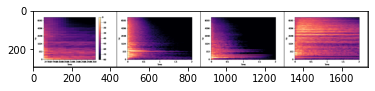

In [20]:
def imgshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    
dataiter = iter(dm.train_loader)
images, labels = next(dataiter)

imgshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #in_channels = 3: RGB
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(115920, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6) #last number = num of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=115920, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dm.train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [53]:
kyoto = DrumsModel('kyoto', classes)

GroundTruth: ck ck ck ck
Predicted: ks ks kick snare


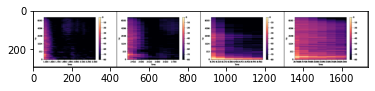

In [21]:
kyoto.predpic()

In [54]:
kyoto.predict()

Epoch 14: model accuracy 0.00%


,pred,drum
0,3,ks
1,3,ks
2,2,kick
3,4,snare
4,2,kick
...,...,...
280,2,kick
281,1,cymbal
282,2,kick
283,2,kick
